In [189]:
import numpy as np
from fractions import Fraction
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

In [190]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))

def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [191]:
def qft_adder(qc,qr,y_val,isless=False):
    # Apply QFT 
    qft = QFT(len(qr), do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(len(qr)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.p(theta, qr[i])
    # Apply inverse QFT 
    iqft = QFT(len(qr), do_swaps=False).inverse()
    qc.append(iqft, qr)
    if isless:
        qc.barrier()
    return qc

In [297]:
def isless(qc,qr, a,c,y_val):
    qft_adder(qc,[*qr,*a],-y_val)
    qc.cx(a,c)
    qft_adder(qc,[*qr,*a],y_val)
    return qc

In [298]:
def Cqft_adder(qc,qr,c,y_val):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1
    """
    # Apply QFT 
    qft = QFT(len(qr), do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(len(qr)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.cp(theta,c,qr[i])
    # Apply inverse QFT 
    iqft = QFT(len(qr), do_swaps=False).inverse()
    qc.append(iqft, qr)
    
    return qc.to_instruction()

In [322]:
def Cisless(qc,qr, a,c,control,y_val):
    Cqft_adder(qc,[*qr,*a],control,-y_val)
    qc.cx(a,c)
    Cqft_adder(qc,[*qr,*a],control,y_val)
    return qc

In [323]:
def addmodN(qc,qr,a,c,y_val,N):
    isless(qc,qr,a,c,N-y_val)
    qft_adder(qc,qr,y_val)
    Cqft_adder(qc,qr,c,-N,)
    # qft_adder(qc,[*qr,*a],-y_val)
    # qc.x(a)
    # qc.cx(a,c)
    # qc.x(a)
    # qft_adder(qc,[*qr,*a],y_val)
    return qc

In [378]:
def CaddmodN(qc,qr,a,c,control,y_val,N):
    c1,c2 = c[0],c[1]
    Cisless(qc,qr,a,c1,control,N) #x<N
    Cisless(qc,qr,a,c2,control,N-y_val)
    qc.barrier() # for adding mod N
    #case c1=true and c2=False
    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)
    qc.barrier()
    Cqft_adder(qc,qr,a,y_val-N)
    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)
    qc.barrier()
    # case c1=True and C2=True
    qc.ccx(c1,c2,a)
    Cqft_adder(qc,qr,a,y_val)
    qc.ccx(c1,c2,a)
    qc.barrier()
    Cisless(qc,qr,a,c2,control, y_val)
    qc.cx(c1,c2)
    Cisless(qc,qr,a,c1,control,y_val)
    return qc

In [399]:
x_val =9
y_val = 1
N_val=11
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 

In [400]:
qr = QuantumRegister(n_qubits,'x')
a = QuantumRegister(1,'a')
c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
# cl = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr,a,c,control)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ.x(qr[i])
circ.x(control)
circ.barrier()
CaddmodN(circ,qr,a,c,control,y_val,N_val)

In [401]:

# circ.measure(circ.qregs[0][:],circ.cregs[0][:n_qubits])
circ.measure_all()

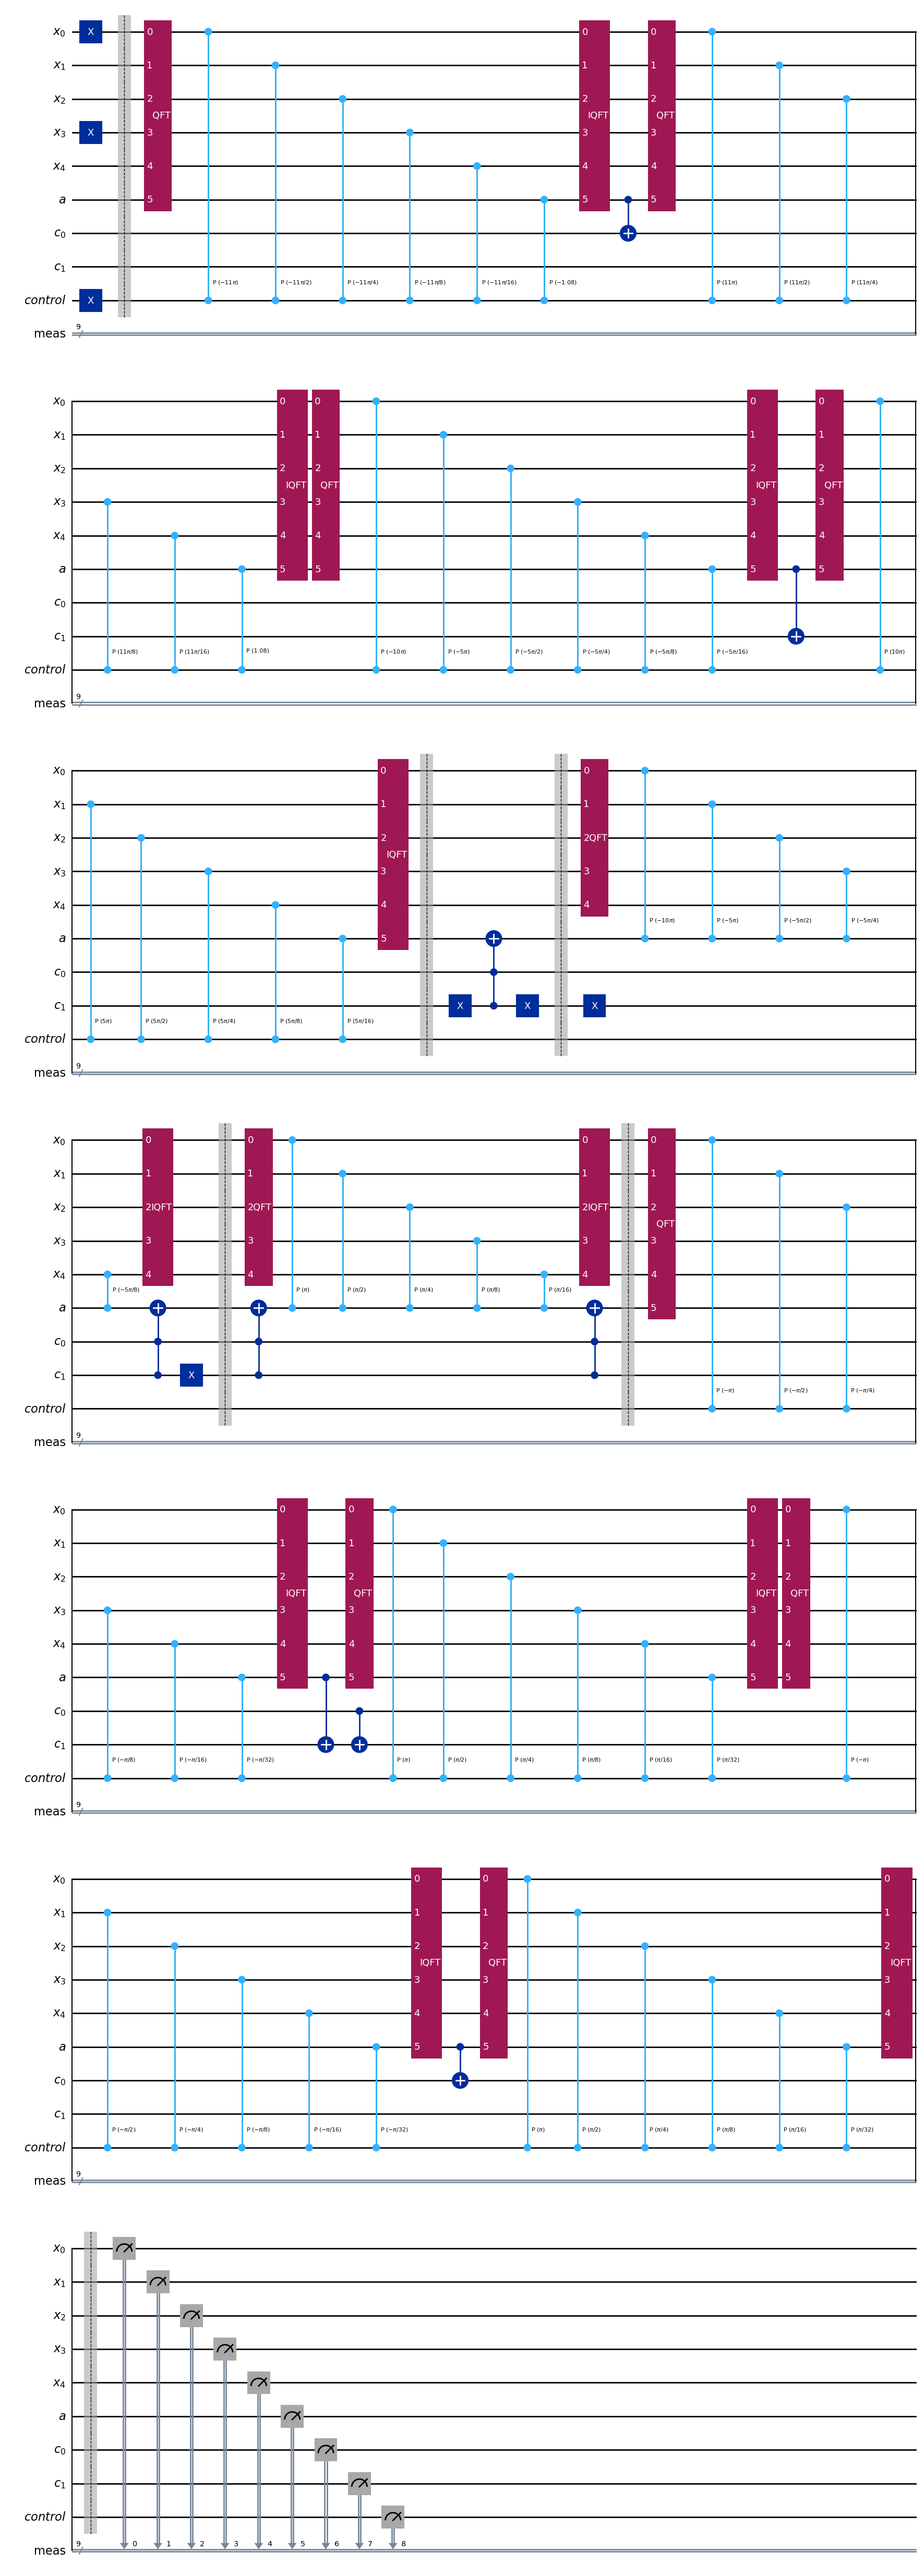

In [402]:
circ.draw('mpl')

In [403]:
np.binary_repr(x_val,n_qubits)

'01001'

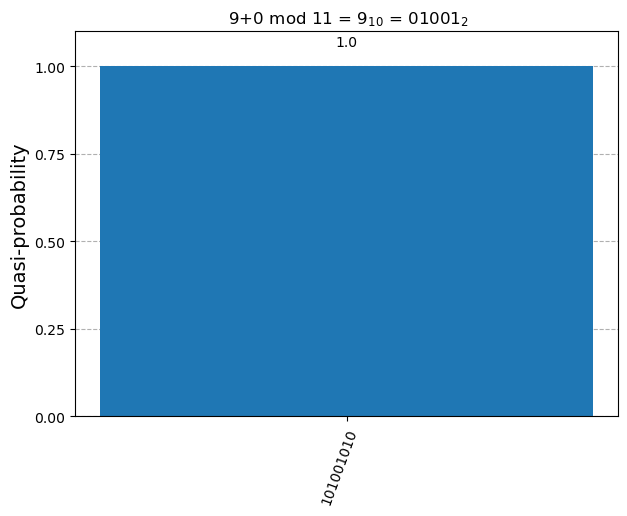

In [404]:
sim(circ,AerSimulator(),1000,x_val,0,N_val,5)

In [339]:
cl1 = ClassicalRegister(2)

In [340]:
qc = QuantumCircuit(qr,a,c,cl1)
for i in range(n_qubits):
        if (9 & (1 << i)):
            qc.x(qr[i])

In [341]:
isless(qc,qr,a,c[0],12)
qc.measure(c,cl1)

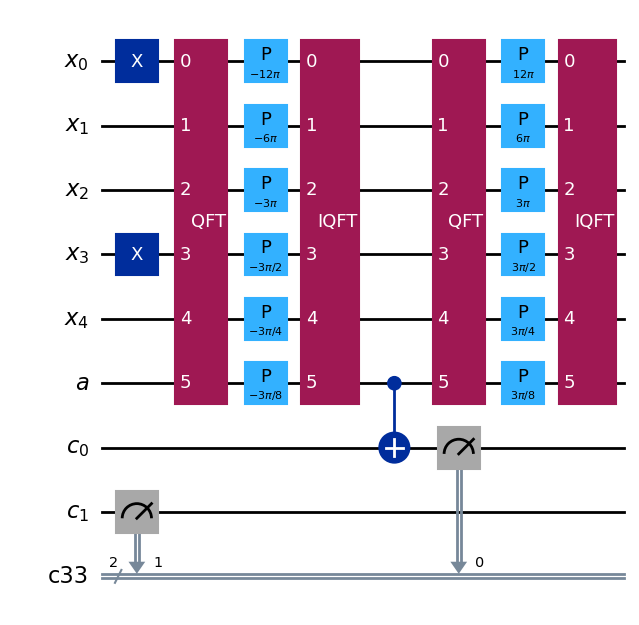

In [342]:
qc.draw('mpl')

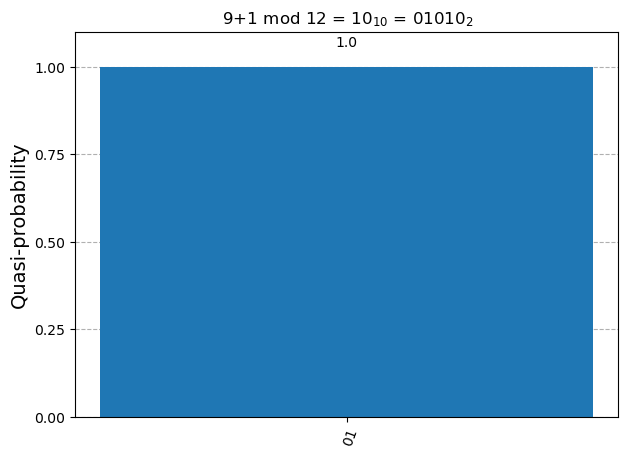

In [343]:
sim(qc,AerSimulator(),1000,x_val,y_val,N_val,5)